In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [23]:
df = pd.read_csv('../dataset/GOOG.csv')
df

,Date,High,Low,Open,Close,Volume,Adj Close
0,2006-01-03,217.021545,208.329132,210.471100,216.802368,26340763.0,216.802368
1,2006-01-04,223.641739,219.053925,221.121185,221.788681,30687394.0,221.788681
2,2006-01-05,224.931900,219.925659,222.167267,224.777481,21697624.0,224.777481
3,2006-01-06,234.371521,225.773743,227.581970,231.960556,35646914.0,231.960556
4,2006-01-09,235.816101,229.609375,232.334152,232.578247,25679694.0,232.578247
...,...,...,...,...,...,...,...
3771,2020-12-24,1746.000000,1729.109985,1735.000000,1738.849976,346800.0,1738.849976
3772,2020-12-28,1790.728027,1746.334961,1751.635010,1776.089966,1393000.0,1776.089966
3773,2020-12-29,1792.439941,1756.089966,1787.790039,1758.719971,1299400.0,1758.719971
3774,2020-12-30,1765.094971,1725.599976,1762.010010,1739.520020,1306100.0,1739.520020


In [36]:
count = int(np.ceil(len(df) * 0.1))
signals = pd.DataFrame(index=df.index)
signals['signal'] = 0.0
signals['trend'] = df['Close']
signals['RollingMax'] = (signals.trend.shift(1).rolling(count).max())
signals['RollingMin'] = (signals.trend.shift(1).rolling(count).min())
r=0.5
# if rolling max *(1+r)< current price  then sell since there is 
# higher probability of falling; similarly rollmin*(1-r)> current price buy
signals.loc[signals['RollingMax'] *(1+r)< signals.trend, 'signal'] = -1
signals.loc[signals['RollingMin'] *(1-r) > signals.trend, 'signal'] = 1
# let's buy the first day, sell last day
signals.signal[0]=1
signals.signal.iloc[-1]=-1

signals

,signal,trend,RollingMax,RollingMin
0,1.0,216.802368,NaN,NaN
1,0.0,221.788681,NaN,NaN
2,0.0,224.777481,NaN,NaN
3,0.0,231.960556,NaN,NaN
4,0.0,232.578247,NaN,NaN
...,...,...,...,...
3771,0.0,1738.849976,1827.98999,1056.619995
3772,0.0,1776.089966,1827.98999,1056.619995
3773,0.0,1758.719971,1827.98999,1056.619995
3774,0.0,1739.520020,1827.98999,1056.619995


In [46]:
def buy_stock(
    real_movement,
    signal,
    initial_money = 10000,
    max_buy = 1000,
    max_sell = 1000,
):
    """
    real_movement = actual movement in the real world
    delay = how much interval you want to delay to change our decision from buy to sell, vice versa
    initial_state = 1 is buy, 0 is sell
    initial_money = 1000, ignore what kind of currency
    max_buy = max quantity for share to buy
    max_sell = max quantity for share to sell
    """
    starting_money = initial_money
    states_sell = []
    states_buy = []
    current_inventory = 0

    def buy(i, initial_money, current_inventory):
        shares = initial_money // real_movement[i]
        if shares < 1:
            print(
                'day %d: total balances %f, not enough money to buy a unit price %f'
                % (i, initial_money, real_movement[i])
            )
        else:
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            initial_money -= buy_units * real_movement[i]
            current_inventory += buy_units
            print(
                'day %d: buy %d units at price %f, total balance %f'
                % (i, buy_units, buy_units * real_movement[i], initial_money)
            )
            states_buy.append(0)
        return initial_money, current_inventory

    for i in range(real_movement.shape[0]):
        state = signal[i]
        if state == 1: # buy signal
            initial_money, current_inventory = buy(
                i, initial_money, current_inventory
            )
            states_buy.append(i)
        elif state == -1: # sell signal
            if current_inventory == 0:
                    print('day %d: cannot sell anything, inventory 0' % (i))
            else:
                if current_inventory > max_sell:
                    sell_units = max_sell
                else:
                    sell_units = current_inventory
                current_inventory -= sell_units
                total_sell = sell_units * real_movement[i]
                initial_money += total_sell
                try:
                    invest = (
                        (real_movement[i] - real_movement[states_buy[-1]])
                        / real_movement[states_buy[-1]]
                    ) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (i, sell_units, total_sell, invest, initial_money)
                )
            states_sell.append(i)
            
    invest = ((initial_money - starting_money) / starting_money) * 100
    total_gains = initial_money - starting_money
    return states_buy, states_sell, total_gains, invest

In [47]:
states_buy, states_sell, total_gains, invest = buy_stock(df.Close, signals['signal'])

day 0: buy 46 units at price 9972.908936, total balance 27.091064
day 3775, sell 46 units at price 80586.480225, investment 708.053906 %, total balance 80613.571289,


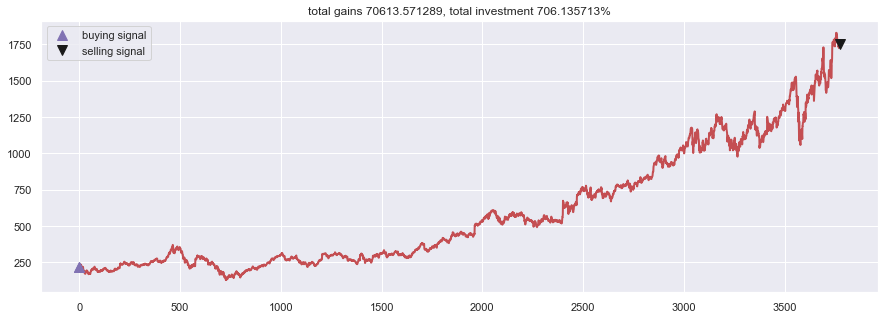

In [48]:
close = df['Close']
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()